# Coding Project 1

Questions:  
Q: how you have split the dataset into train, text, validation?  
A: Yes

Q: have you taken any methods to compensate for class imbalance?  
A: Oversampling of minor classes

Q: present the training/validation loss curves and indicate how you have chosen the stopping criteria?  
A: Training/ validation loss curves are plotted. Stopping criteria is the best validation loss.

Q: any conditions of hot restart during training?  
A: I have added a `load_checkpoint` function, after the augmentation section which does the same and used this after that section. Updates the final model after every epoch and resumes training if training is completed or aborted from last saved checkpoint.

Q: calculate the model space and inference compute complexity and indicate it on your .ipynb  
A: Number of parameters in LeNet: 43682

Template is taken from course's github [repo](https://github.com/iitkliv/ai61002_Spr2020/blob/master/Tutorial4_Training_LeNet_using_GD.ipynb), and some code is taken from my own submission in a [kaggle competition](https://www.kaggle.com/c/digit-recognizer)

### Importing libraries

In [10]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

import seaborn as sns
from PIL import Image
from collections import Counter
from sklearn.utils import resample
from skimage import io, transform

In [11]:
import sys
import random
import os

import numpy as np

# torch.manual_seed(1)
# torch.cuda.manual_seed(1)
# np.random.seed(1)
# random.seed(1)
# torch.backends.cudnn.deterministic = True

### Loading dataset

In [12]:
#Listing file and folders in current directory
!ls

BDRW_train  BDRW_train_1  BDRW_train_2	data.zip  hello  Untitled.ipynb


In [13]:
# Checking number of images in BDRW_train_1 direcory
len(os.listdir("./BDRW_train_1/BDRW_train_1"))

984

In [14]:
# Checking number of images in BDRW_train_2 directory
len(os.listdir("./BDRW_train_2/BDRW_train_2"))

410

BDRW_train_2 contain a labels.xls file containing labels

In [15]:
labels = pd.read_excel("./BDRW_train_2/BDRW_train_2/labels.xls")
labels

,digit_0,1
0,digit_1,4
1,digit_2,2
2,digit_3,3
3,digit_4,1
4,digit_5,2
...,...,...
1387,digit_1542,0
1388,digit_1544,5
1389,digit_1545,0
1390,digit_1546,3


Note that first line in above dataset is digit_0 and 1, we need to fix that  
also note 984 + 410 - 1 = 1393  
[Pandas: Reading excel files when the first row is NOT the column name Excel Files](https://stackoverflow.com/questions/51733136/pandas-reading-excel-files-when-the-first-row-is-not-the-column-name-excel-file)

In [16]:
labels = pd.read_excel("./BDRW_train_2/BDRW_train_2/labels.xls", header=None)
labels

,0,1
0,digit_0,1
1,digit_1,4
2,digit_2,2
3,digit_3,3
4,digit_4,1
...,...,...
1388,digit_1542,0
1389,digit_1544,5
1390,digit_1545,0
1391,digit_1546,3


### EDA

In [17]:
labels[1].value_counts()

1    282
2    211
0    166
3    133
5    126
4    124
6     98
7     89
8     83
9     81
Name: 1, dtype: int64

Clearly imbalanced dataset

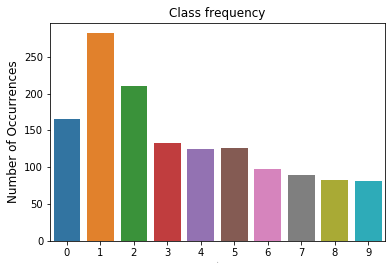

In [18]:
frequencies = labels[1].value_counts()
sns.barplot(frequencies.index, frequencies.values)
plt.title('Class frequency')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('city', fontsize=1)
plt.show()

Few techniques to try for imbalance datasets:
* Oversampling minority classes
* Undersampling majority classes (Will not use this)
* Generate synthethic samples (Will not use this)
* Scraping some data from internet to make class balanced (Will not use this)

#### Visualising few images

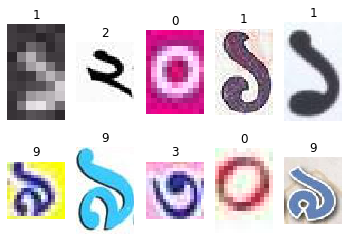

In [19]:
# Taking 10 random images and plotting them with their class on top of image
FOLDERS = ["BDRW_train_1/BDRW_train_1/", "BDRW_train_2/BDRW_train_2/"]
fig, ax = plt.subplots(nrows=2, ncols=5)

for row in ax:
    for col in row:
        #randomly selecting an image from dataset
        img_name, img_class = labels.loc[random.randrange(labels.shape[0])]
        image = None
        # image has to be in one of the two folders given
        try :
            image = Image.open(FOLDERS[0] + img_name + ".jpg")
        except:
            image = Image.open(FOLDERS[1] + img_name + ".jpg")
            
        col.imshow(image)
        col.set_title(img_class)
        col.axis('off')

plt.show()

Images doesn't have same size, will have to resize accordingly

#### Checking image sizes

In [20]:
store_image_sizes  = []

for index, (image_name, image_class) in labels.iterrows():
    # image has to be in one of the two folders given
    image = None
    try :
        image = Image.open(FOLDERS[0] + image_name + ".jpg")
    except:
        image = Image.open(FOLDERS[1] + image_name + ".jpg")
    store_image_sizes.append(image.size)


In [21]:
store_image_sizes

[(16, 26),
 (14, 26),
 (25, 28),
 (24, 25),
 (19, 27),
 (27, 30),
 (27, 26),
 (17, 26),
 (21, 26),
 (22, 26),
 (23, 28),
 (26, 26),
 (21, 26),
 (18, 22),
 (17, 27),
 (19, 25),
 (15, 26),
 (22, 27),
 (15, 26),
 (24, 26),
 (18, 27),
 (17, 24),
 (17, 25),
 (19, 24),
 (17, 26),
 (21, 25),
 (18, 27),
 (21, 26),
 (17, 28),
 (27, 29),
 (17, 28),
 (25, 29),
 (28, 29),
 (21, 28),
 (25, 30),
 (24, 29),
 (24, 30),
 (23, 25),
 (22, 28),
 (16, 27),
 (24, 29),
 (19, 28),
 (23, 29),
 (21, 25),
 (23, 30),
 (22, 29),
 (26, 30),
 (24, 28),
 (21, 26),
 (22, 27),
 (19, 24),
 (25, 28),
 (18, 26),
 (14, 19),
 (14, 17),
 (14, 18),
 (16, 17),
 (17, 16),
 (10, 19),
 (11, 23),
 (12, 22),
 (12, 22),
 (11, 24),
 (13, 15),
 (12, 14),
 (13, 14),
 (11, 17),
 (14, 21),
 (14, 20),
 (18, 20),
 (17, 19),
 (17, 19),
 (20, 18),
 (19, 18),
 (19, 19),
 (21, 29),
 (13, 18),
 (12, 18),
 (14, 18),
 (13, 15),
 (38, 55),
 (12, 15),
 (11, 14),
 (47, 62),
 (43, 46),
 (44, 46),
 (22, 18),
 (16, 17),
 (17, 17),
 (15, 17),
 (14, 14),

In [22]:
# using Counter from collections library to get frequency of each size unique image size in store_image_sizes
freq_of_image_sizes = Counter(store_image_sizes)
# Checking how many different sizes of images are there
len(freq_of_image_sizes)

671

In [23]:
# alternative way without using Counter
temp = set(store_image_sizes)
len(temp)

671

### Splitting dataset into train, validation and test set

Can either use train, validation and test splitting in pytorch dataloader or can divide this labels dataset (which contains all image file names and their respective classes) into 3 different dataframe.
Choosing the latter one

Method below is copied from a stackoverflow answer: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test

In [24]:
# 80, 10, 10 split
train, validate, test = np.split(labels.sample(frac=1), [int(.8*len(labels)), int(.9*len(labels))])

In [25]:
train

,0,1
966,digit_1072,3
439,digit_485,5
876,digit_971,3
1323,digit_1472,8
478,digit_525,3
...,...,...
476,digit_523,2
781,digit_867,4
454,digit_500,4
1260,digit_1404,1


In [26]:
train[1].value_counts()

1    224
2    169
0    119
3    113
5    102
4    100
6     81
7     76
8     66
9     64
Name: 1, dtype: int64

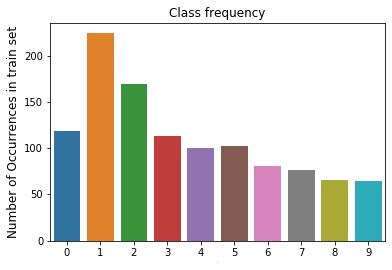

In [27]:
sns.barplot(train[1].value_counts().index, train[1].value_counts().values)
plt.title('Class frequency')
plt.ylabel('Number of Occurrences in train set', fontsize=12)
plt.xlabel('city', fontsize=1)
plt.show()

### Oversampling
train set

Just selecting that class with maximum number of photos and then randomly selecting same number of photos from other class with replacement 

In [28]:
frequency_dict = train[1].value_counts()
max_freq = frequency_dict[frequency_dict.index[0]] # 1 as counter indexes in decreasing order

In [29]:
frequency_dict.shape[0]

10

In [30]:
store_all = []
for i in range(frequency_dict.shape[0]):
    temp_df = labels[labels[1] == i]
    temp_df_upsampled = resample(temp_df, replace=True, n_samples=max_freq, random_state=42)
    store_all.append(temp_df_upsampled)

upsampled_df = pd.concat(store_all)

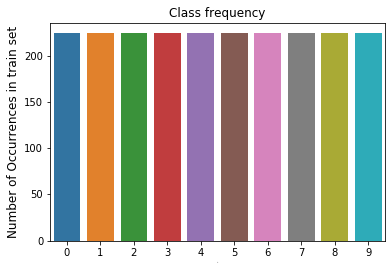

In [31]:
# just checking if dataframe is oversampled correctly and is now balanced or not
upsampled_value_counts = upsampled_df[1].value_counts()
sns.barplot(upsampled_value_counts.index, upsampled_value_counts.values)
plt.title('Class frequency')
plt.ylabel('Number of Occurrences in train set', fontsize=12)
plt.xlabel('city', fontsize=1)
plt.show()

As evident from above plot, classes are balanced

## Making custom dataloader

Have already used Lenet which uses 32x32 images, let's convert all images to 32x32

In [32]:
class BengaliDigitDataset(Dataset):
    
    def __init__(self, df, is_test, transform=None):
        self.data = df
        self.transform = transform
        self.test = is_test
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name = self.data.iloc[index, 0]
        img = None
        # image has to be in one of the two folders given
        try :
            image = Image.open(FOLDERS[0] + img_name + ".jpg")
        except:
            image = Image.open(FOLDERS[1] + img_name + ".jpg")
        label = None
        try:
            label = self.data.iloc[index, 1]
        except:
            pass
        
        if self.transform is not None:
            # converting image to black and white
            image = image.convert('1')
            # applying transforms
            image = self.transform(image)
        
        # for train loader it returns label and image both but for test loader returns only image 
        if self.test:
            return image
        else:
            return image, label

In [ ]:
apply_transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
BatchSize = 4

train_ = BengaliDigitDataset(upsampled_df, False, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(train_, batch_size=BatchSize,
                                          shuffle=True, num_workers=0) # Creating dataloader

validate_ = BengaliDigitDataset(validate, False, transform=apply_transform)
validateLoader = torch.utils.data.DataLoader(validate_, batch_size=BatchSize,
                                          shuffle=False, num_workers=0)

### Model

Using LeNet model

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

### Training

In [222]:
use_gpu = torch.cuda.is_available()
net = LeNet()
print(net)
if use_gpu:
    print('GPU is avaialble!')
    net = net.cuda()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
GPU is avaialble!


In [223]:
criterion = nn.CrossEntropyLoss() 
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
num_epochs = 20

best_validation_loss = 1e9 # initializing with very high error

train_loss = []
train_acc = []
for epoch in range(num_epochs):
    running_loss = 0.0 
    running_corr = 0
    
    for i,data in enumerate(trainLoader):
        
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda() 
        # Initializing model gradients to zero
        # optimizer.zero_grad()
        # Both optimizer.zero_grad() and net.zero_grad() works the same
        # See: https://discuss.pytorch.org/t/model-zero-grad-or-optimizer-zero-grad/28426/4
        net.zero_grad() 
        # Data feed-forward through the network
        outputs = net(inputs)
        # Predicted class is the one with maximum probability
        preds = torch.argmax(outputs,dim=1)
        # Finding the loss
        loss = criterion(outputs, labels)
        # Accumulating the loss for each batch
        running_loss += loss 
        # Accumulate number of correct predictions
        running_corr += torch.sum(preds==labels)  
        loss.backward()
        
        optimizer.step()
    # save lastest
    states = {
        'epoch': num_epochs,
        'state_dict': net.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(states, "./Latest_LeNet_SGD_0_08.mdl")
    epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
    epoch_acc = running_corr.item()/len(upsampled_df)
    
    train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
    train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
    
    
    # stopping criteria
    curr_validation_loss = 0.0
    for i, data in enumerate(validateLoader):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        preds_ = torch.argmax(outputs, dim=1)
        loss_ = criterion(outputs, labels)
        curr_validation_loss += loss_
    
    if curr_validation_loss < best_validation_loss:
        #best model
        states = {
            'epoch': num_epochs,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(states, "./Best_LeNet_0_08.mdl")
        best_validation_loss = curr_validation_loss
    else:
        #early stopping
        
        break
    
        
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))


Epoch 1/20 : Training loss: 2.3015 | Training Accuracy: 11.7857
Epoch 2/20 : Training loss: 2.2881 | Training Accuracy: 17.9911
Epoch 3/20 : Training loss: 2.1467 | Training Accuracy: 29.7321
Epoch 4/20 : Training loss: 1.3599 | Training Accuracy: 56.8750
Epoch 5/20 : Training loss: 0.7662 | Training Accuracy: 74.9554
Epoch 6/20 : Training loss: 0.4636 | Training Accuracy: 85.5804
Epoch 7/20 : Training loss: 0.2916 | Training Accuracy: 91.3393


Text(0, 0.5, 'Training')

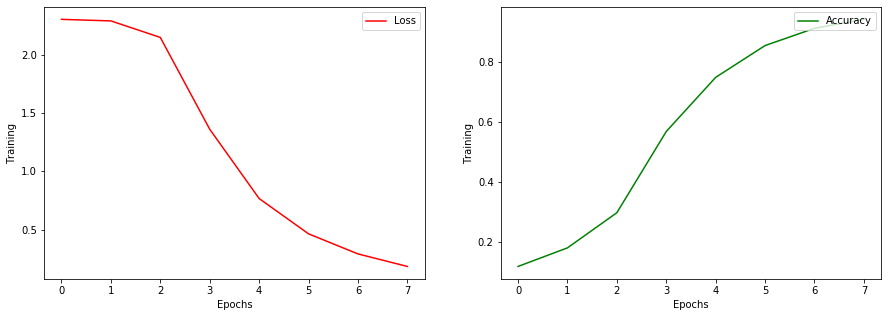

In [226]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(len(train_loss)),train_loss,'r-',label='Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(122)
plt.plot(range(len(train_acc)),train_acc,'g-',label='Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

In [227]:
correct_pred = 0
for data in validateLoader:
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)

test_accuracy = correct_pred.item()/len(validate)
print('Validation accuracy = ',test_accuracy*100)

Validation accuracy =  88.48920863309353


pretty good result with no augmentation

### Using augmentation

In [229]:
apply_transform = transforms.Compose([transforms.Resize((32, 32)), transforms.RandomRotation((-5, 5), resample=False), transforms.ToTensor()])
BatchSize = 4

train_ = BengaliDigitDataset(upsampled_df, False, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(train_, batch_size=BatchSize,
                                          shuffle=True, num_workers=0) # Creating dataloader

validate_ = BengaliDigitDataset(validate, False, transform=apply_transform)
validateLoader = torch.utils.data.DataLoader(validate_, batch_size=BatchSize,
                                          shuffle=False, num_workers=0)

In [233]:
use_gpu = torch.cuda.is_available()
net = LeNet()
print(net)
if use_gpu:
    print('GPU is avaialble!')
    net = net.cuda()



LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
GPU is avaialble!


In [234]:
criterion = nn.CrossEntropyLoss() 
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
num_epochs = 60

best_validation_loss = 1e9 # initializing with very high error

train_loss = []
train_acc = []
for epoch in range(num_epochs):
    running_loss = 0.0 
    running_corr = 0
    
    for i,data in enumerate(trainLoader):
        
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda() 
        # Initializing model gradients to zero
        # optimizer.zero_grad()
        # Both optimizer.zero_grad() and net.zero_grad() works the same
        # See: https://discuss.pytorch.org/t/model-zero-grad-or-optimizer-zero-grad/28426/4
        net.zero_grad() 
        # Data feed-forward through the network
        outputs = net(inputs)
        # Predicted class is the one with maximum probability
        preds = torch.argmax(outputs,dim=1)
        # Finding the loss
        loss = criterion(outputs, labels)
        # Accumulating the loss for each batch
        running_loss += loss 
        # Accumulate number of correct predictions
        running_corr += torch.sum(preds==labels)  
        loss.backward()
        
        optimizer.step()
    # save lastest
    states = {
        'epoch': num_epochs,
        'state_dict': net.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(states, "./Latest_LeNet_SGD_0_08.mdl")
    epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
    epoch_acc = running_corr.item()/len(upsampled_df)
    
    train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
    train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
    
    
    # stopping criteria
    curr_validation_loss = 0.0
    for i, data in enumerate(validateLoader):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        preds_ = torch.argmax(outputs, dim=1)
        loss_ = criterion(outputs, labels)
        curr_validation_loss += loss_
    
    if curr_validation_loss < best_validation_loss:
        #best model
        states = {
            'epoch': num_epochs,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(states, "./Best_LeNet_0_08.mdl")
        best_validation_loss = curr_validation_loss
    else:
        #early stopping
        
        break
    
        
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))


Epoch 1/60 : Training loss: 2.3021 | Training Accuracy: 11.0714
Epoch 2/60 : Training loss: 2.2869 | Training Accuracy: 17.6339
Epoch 3/60 : Training loss: 2.0901 | Training Accuracy: 32.6786
Epoch 4/60 : Training loss: 1.2197 | Training Accuracy: 63.1696
Epoch 5/60 : Training loss: 0.6238 | Training Accuracy: 79.9107
Epoch 6/60 : Training loss: 0.3796 | Training Accuracy: 87.4554
Epoch 7/60 : Training loss: 0.2306 | Training Accuracy: 92.9911
Epoch 8/60 : Training loss: 0.1735 | Training Accuracy: 94.9554
Epoch 9/60 : Training loss: 0.1114 | Training Accuracy: 96.6964
Epoch 10/60 : Training loss: 0.0874 | Training Accuracy: 97.2768
Epoch 11/60 : Training loss: 0.0786 | Training Accuracy: 97.8571
Epoch 12/60 : Training loss: 0.0674 | Training Accuracy: 97.7679
Epoch 13/60 : Training loss: 0.0585 | Training Accuracy: 98.3929
Epoch 14/60 : Training loss: 0.0219 | Training Accuracy: 99.4643
Epoch 15/60 : Training loss: 0.0381 | Training Accuracy: 99.1518
Epoch 16/60 : Training loss: 0.063

KeyboardInterrupt: 

Text(0, 0.5, 'Training')

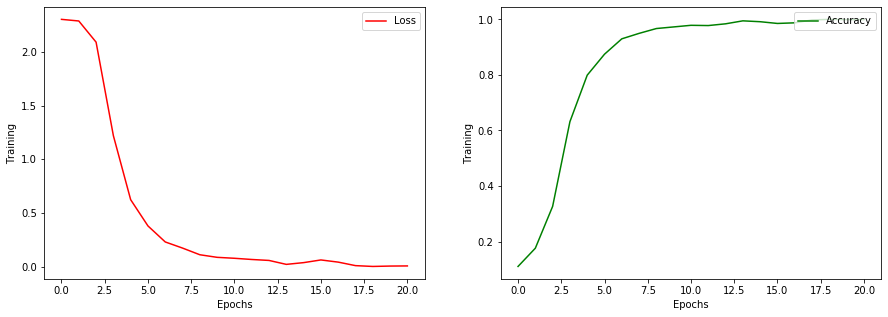

In [235]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(len(train_loss)),train_loss,'r-',label='Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')
plt.subplot(122)
plt.plot(range(len(train_acc)),train_acc,'g-',label='Accuracy') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

In [236]:
correct_pred = 0
for data in validateLoader:
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)

test_accuracy = correct_pred.item()/len(validate)
print('Validation accuracy = ',test_accuracy*100)

Validation accuracy =  96.40287769784173


### Loading saved models and optimiser state

Taken from : https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/3

In [145]:
# saving optimizer and model
states = {
        'epoch': num_epochs,
        'state_dict': net.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
torch.save(states, "./LeNet_SGD_0_08_60.mdl")

def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename)
    epoch = checkpoint["epoch"]
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, epoch

In [147]:
net = LeNet()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)


model, optimizer, start_epoch = load_checkpoint(net, optimizer, "LeNet_SGD_0_08_60.mdl")
model = model.cuda()

# now individually transfer the optimizer parts
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

Trying few epochs

In [148]:
train_loss = []
train_acc = []
for epoch in range(start_epoch, start_epoch+2):
    running_loss = 0.0 
    running_corr = 0
    
    for i,data in enumerate(trainLoader):
        
        inputs,labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda() 
        # Initializing model gradients to zero
        # optimizer.zero_grad()
        # Both optimizer.zero_grad() and net.zero_grad() works the same
        # See: https://discuss.pytorch.org/t/model-zero-grad-or-optimizer-zero-grad/28426/4
        net.zero_grad() 
        # Data feed-forward through the network
        outputs = net(inputs)
        # Predicted class is the one with maximum probability
        preds = torch.argmax(outputs,dim=1)
        # Finding the loss
        loss = criterion(outputs, labels)
        # Accumulating the loss for each batch
        running_loss += loss 
        # Accumulate number of correct predictions
        running_corr += torch.sum(preds==labels)  
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
    epoch_acc = running_corr.item()/len(upsampled_df)
    
    
         
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc) 
       
        
    print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))


Epoch 61/60 : Training loss: 0.0790 | Training Accuracy: 98.1696
Epoch 62/60 : Training loss: 0.0747 | Training Accuracy: 98.2589


Loss and accuracy is nearly the same, hence this method of saving model and optimizer state is working

### Trying lenet with different parameters

Batch size: 128
Epoch 1/50 : Training loss: 2.3041 | Training Accuracy: 10.1786
Epoch 2/50 : Training loss: 2.3016 | Training Accuracy: 10.0000
Epoch 3/50 : Training loss: 2.2993 | Training Accuracy: 11.6964
Epoch 4/50 : Training loss: 2.2964 | Training Accuracy: 14.2411
Epoch 5/50 : Training loss: 2.2927 | Training Accuracy: 18.0357
Epoch 6/50 : Training loss: 2.2866 | Training Accuracy: 22.9464
Epoch 7/50 : Training loss: 2.2742 | Training Accuracy: 25.0000
Epoch 8/50 : Training loss: 2.2444 | Training Accuracy: 31.4732
Epoch 9/50 : Training loss: 2.1718 | Training Accuracy: 27.5000
Epoch 10/50 : Training loss: 2.0434 | Training Accuracy: 32.0982
Epoch 11/50 : Training loss: 1.8491 | Training Accuracy: 40.1786
Epoch 12/50 : Training loss: 1.6233 | Training Accuracy: 49.8214
Epoch 13/50 : Training loss: 1.3776 | Training Accuracy: 58.2143
Epoch 14/50 : Training loss: 1.1877 | Training Accuracy: 62.4107
Epoch 15/50 : Training loss: 1.0143 | Training Accuracy: 66.8750
Epoch 16/50 : Trai

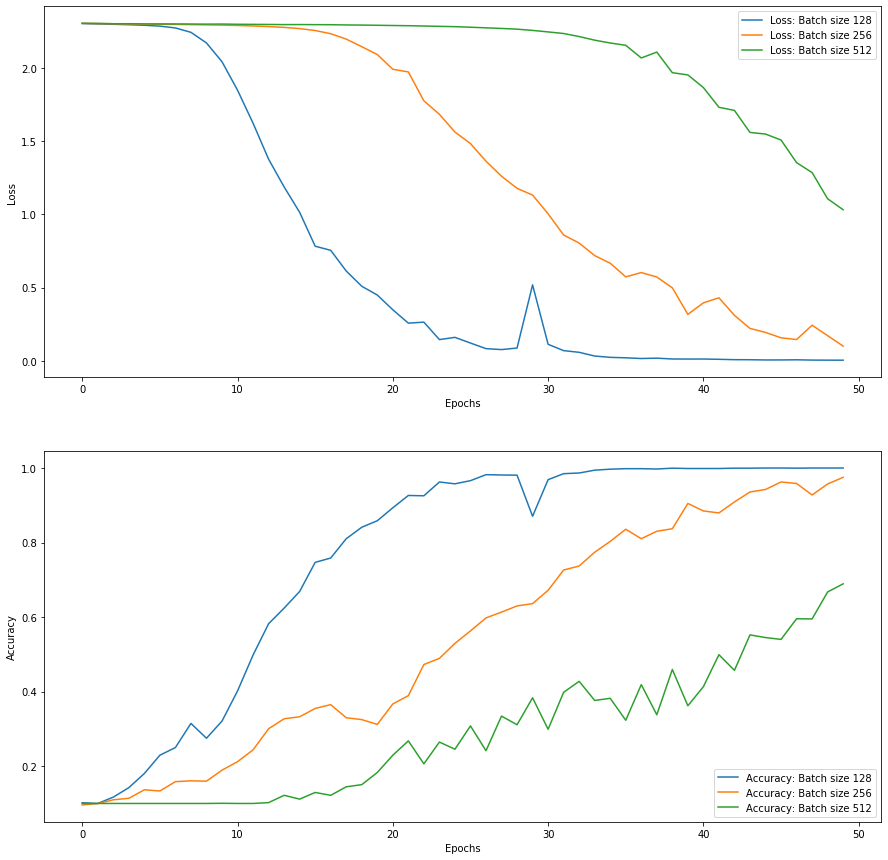

In [205]:
batch_sizes = [128, 256, 512]

# Plots axes, size and labels
f, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))
ax1.set_xlabel(f'Epochs')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
cols = ['Loss', 'Accuracy']

test_accuracies = []
num_epochs = 50
learning_rate = 0.08
for fig_num, batch_size in enumerate(batch_sizes):
    print(f"Batch size: {batch_size}" )
    
    file_name = f"LeNet_{batch_size}_{learning_rate}" # model will be saved with this filename
    best_validation_loss = 1e9 # initializing with very high error
    
    
    trainLoader = torch.utils.data.DataLoader(train_, batch_size=batch_size, shuffle=True, num_workers=0) 

    # Validation set with random rotations in the range [-90,90]
    validateLoader = torch.utils.data.DataLoader(validate_, batch_size=batch_size, shuffle=False, num_workers=0) 
    net = LeNet()
    if use_gpu:
        net = net.cuda()
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []
    for epoch in range(num_epochs):

        running_loss = 0.0 
        running_corr = 0

        for i,data in enumerate(trainLoader):

            inputs,labels = data
            if use_gpu:
                inputs, labels = inputs.cuda(),labels.cuda() 
            # Initializing model gradients to zero
            # optimizer.zero_grad()
            net.zero_grad() 
            # Data feed-forward through the network
            outputs = net(inputs)
            # Predicted class is the one with maximum probability
            preds = torch.argmax(outputs,dim=1)
            # Finding the loss
            loss = criterion(outputs, labels)
            # Accumulating the loss for each batch
            running_loss += loss 
            # Accumulate number of correct predictions
            running_corr += torch.sum(preds==labels)  
            loss.backward()
            optimizer.step()

        
        epoch_loss = running_loss.item()/(i+1)   #Total loss for one epoch
        epoch_acc = running_corr.item()/len(upsampled_df)



        train_loss.append(epoch_loss) #Saving the loss over epochs for plotting the graph
        train_acc.append(epoch_acc) #Saving the accuracy over epochs for plotting the graph


        print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_acc*100))  
    # Plotting with legends on the same axes ax1 and ax2
    ax1.plot(range(num_epochs),train_loss,label= f'Loss: Batch size {batch_size}') 
    ax2.plot(range(num_epochs),train_acc,label=f'Accuracy: Batch size {batch_size}') 
    ax1.legend(loc="upper right")
    ax2.legend(loc="lower right")
    correct_pred = 0
    
    # save lastest
    states = {
        'epoch': num_epochs,
        'state_dict': net.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(states, "./Latest_" + file_name)
    
    # stopping criteria and calculating validation accuracy
    curr_validation_loss = 0.0
    for i, data in enumerate(validateLoader):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        preds_ = torch.argmax(outputs, dim=1)
        loss_ = criterion(outputs, labels)
        curr_validation_loss += loss_
        correct_pred += torch.sum(preds_==labels)
    
    if curr_validation_loss < best_validation_loss:
        #best model
        states = {
            'epoch': num_epochs,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        torch.save(states, "./Best_" + file_name)
    else:
        # no early stopping here, just to see how plot varies
        pass
    

    validation_accuracy = correct_pred.item()/len(validate)
    print('validation accuracy = ',validation_accuracy*100)
    test_accuracies.append(test_accuracy*100)
plt.show()

for bigger batch size learning rate will be higher and thats why for higher batch size accuracy is low

### Testing

In [237]:
test_ = BengaliDigitDataset(test, False, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(test_, batch_size=BatchSize,
                                          shuffle=False, num_workers=0)

In [238]:
# loading best model
net = LeNet()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)


model, optimizer, start_epoch = load_checkpoint(net, optimizer, "./Best_LeNet_0_08.mdl")
model = model.cuda()

# now individually transfer the optimizer parts
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

In [239]:
correct_pred = 0
for data in testLoader:
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)
    

test_accuracy = correct_pred.item()/len(validate)
print('Testing accuracy = ',test_accuracy*100)

Testing accuracy =  97.84172661870504
